<a href="https://colab.research.google.com/github/patdring/StockTrendForecaster/blob/main/StockPriceN_BEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 Training loss: 0.4145521522 Validation loss: 1.2641714439
epoch:   1 Training loss: 0.0102823721 Validation loss: 0.1070642248
epoch:   2 Training loss: 0.0084360801 Validation loss: 0.1038825876
epoch:   3 Training loss: 0.1069398820 Validation loss: 0.3885002481
epoch:   4 Training loss: 0.0150706144 Validation loss: 0.1519927911
epoch:   5 Training loss: 0.0343274251 Validation loss: 0.1586905015
epoch:   6 Training loss: 0.0319729298 Validation loss: 0.0903757956
epoch:   7 Training loss: 0.3904089928 Validation loss: 1.2814864479
epoch:   8 Training loss: 0.0023372856 Validation loss: 0.0536766915
epoch:   9 Training loss: 0.2059434950 Validation loss: 0.0406302334
epoch:  10 Training loss: 0.1036390513 Validation loss: 0.4171012295
epoch:  11 Training loss: 0.0266851000 Validation loss: 0.0271538657
epoch:  12 Training loss: 0.0078485217 Validation loss: 0.0614312123
epoch:  13 Training loss: 0.0186087005 Validation loss: 0.1516112880
epoch:  14 Training loss: 0.059417

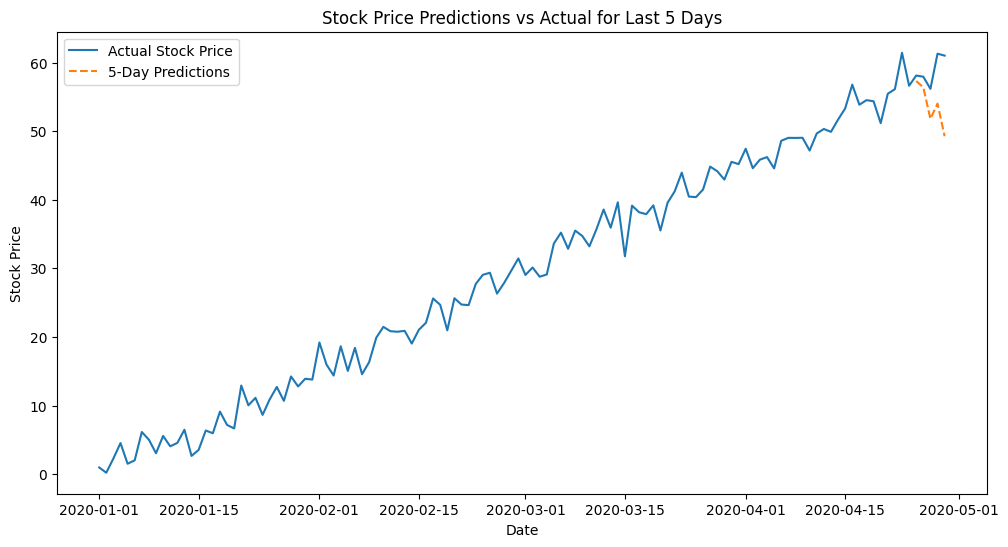

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime

# Generate simulated data
np.random.seed(42)
num_data_points = 120
stock_prices = np.random.randn(num_data_points) * 2 + np.arange(num_data_points) * 0.5
economic_data = stock_prices * 0.3 + np.random.randn(num_data_points) * 0.5
temperature_data = stock_prices * 0.1 + 20 + np.random.randn(num_data_points) * 5
sentiment_data = stock_prices * 0.05 + np.random.uniform(-1, 1, num_data_points)
combined_data = np.vstack((stock_prices, economic_data, temperature_data, sentiment_data)).T

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)
data = torch.from_numpy(scaled_data).float()

# N-BEATS Model Definition
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_units, backcast_length, forecast_length):
        super(NBeatsBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, theta_size)
        )

        self.backcast_fc = nn.Linear(theta_size, backcast_length)
        self.forecast_fc = nn.Linear(theta_size, forecast_length)

    def forward(self, x):
        theta = self.fc(x)
        backcast = self.backcast_fc(theta)
        forecast = self.forecast_fc(theta)
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, input_size, theta_size, hidden_units, num_blocks, backcast_length, forecast_length, dropout_rate=0.3):
        super(NBeats, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(NBeatsBlock(input_size, theta_size, hidden_units, backcast_length, forecast_length))
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        backcasts, forecasts = [], []
        for block in self.blocks:
            x = self.dropout(x)
            backcast, forecast = block(x)
            x = x - backcast
            backcasts.append(backcast)
            forecasts.append(forecast)
        return torch.sum(torch.stack(forecasts, dim=-1), dim=-1)

# Preparing input sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1, 0]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Split data into training and validation sets
train_size = int(len(data) * 0.8)
val_size = len(data) - train_size
train_data, val_data = torch.split(data, [train_size, val_size])

# Adjusted hyperparameters
input_size = 4 * 8
theta_size = 20
hidden_units = 128  # Increased hidden units
num_blocks = 3      # Increased number of blocks
backcast_length = input_size
forecast_length = 1
dropout_rate = 0.1  # Dropout rate

model = NBeats(input_size, theta_size, hidden_units, num_blocks, backcast_length, forecast_length, dropout_rate)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Decreased LR and added weight decay

# Learning rate scheduler adjustment
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

batch_size = 4  # Decreased batch size
train_seq_length = 8  # Sequence length
early_stopping_patience = 25  # Increased patience

def create_mini_batches(data, batch_size, seq_length):
    inout_seq = create_inout_sequences(data, seq_length)
    return [inout_seq[i:i + batch_size] for i in range(0, len(inout_seq), batch_size)]

# Early Stopping parameters
min_val_loss = np.inf
patience_counter = 0

epochs = 100
for i in range(epochs):
    model.train()
    for batch in create_mini_batches(train_data, batch_size, train_seq_length):
        optimizer.zero_grad()
        batch_loss = 0
        for seq, labels in batch:
            seq = seq.reshape(-1, input_size)
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            batch_loss += loss
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # Gradient clipping
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for seq, labels in create_inout_sequences(val_data, train_seq_length):
            seq = seq.reshape(-1, input_size)
            y_pred = model(seq)
            val_loss = loss_function(y_pred, labels)
            val_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_losses) if val_losses else np.inf
    scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

    print(f'epoch: {i:3} Training loss: {batch_loss.item()/len(batch):10.10f} Validation loss: {avg_val_loss:10.10f}')

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Prepare test data for last 5 days
test_inputs = data[-35:, :].tolist()  # Last 30 data points for input, plus 5 for prediction

# Perform predictions for last 5 days
model.eval()
predicted_stock_prices = []
for i in range(5):
    # Extract the relevant slice of test inputs
    input_seq = test_inputs[-train_seq_length:]  # Take the last 'train_seq_length' sequences
    seq = torch.FloatTensor(input_seq)
    seq = seq.reshape(1, -1)  # Reshape to [1, input_size]

    with torch.no_grad():
        prediction = model(seq).item()

        # Append the prediction in the correct format
        next_input = [prediction] + [0] * 3  # Assuming other features are zero or placeholder
        test_inputs.append(next_input)  # Append as a list to maintain structure
        test_inputs.pop(0)  # Remove the oldest point to maintain the sequence length

        predicted_stock_prices.append(prediction)

# Inverse transform the predicted values for last 5 days
predicted_stock_prices = np.array(predicted_stock_prices).reshape(-1, 1)
predicted_stock_prices = scaler.inverse_transform(np.hstack([predicted_stock_prices, np.zeros((5, 3))]))[:, 0]

# Generate dates for plotting
dates = [datetime.date(2020, 1, 1) + datetime.timedelta(days=i) for i in range(num_data_points)]

# Plot the results with actual stock prices for last 5 days
plt.figure(figsize=(12, 6))
plt.plot(dates, stock_prices, label='Actual Stock Price')
plt.plot(dates[-5:], predicted_stock_prices, label='5-Day Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Predictions vs Actual for Last 5 Days')
plt.legend()
plt.show()
